# Pre-processing of GLAMOS MB data:

Does the pre-processing of the point MB measurements from GLAMOS (winter and summer).

# Point Mass Balance data:

## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import glob

import zipfile
from pathlib import Path


#from cmcrameri import cm
from calendar import monthrange

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
#from scripts.plots import *
from scripts.config_FR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


cfg = mbm.SwitzerlandConfig()

In [5]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

OSError: 'scripts/example.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## 1. Unzip Glacier Stake Files 

In [2]:

# Base directories
glacioclim_dir = Path('/home/mburlet/DATA_MBM/GLACIOCLIM')
unzipped_dir = glacioclim_dir / 'unzipped'

# Seasonal folders to look for
seasons = ['annual', 'summer', 'winter']

# Create unzipped directory
unzipped_dir.mkdir(parents=True, exist_ok=True)

read_in = False

if read_in == True:
    emptyfolder('/home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/')

    # Process each glacier directory
    for glacier_dir in glacioclim_dir.glob('*Glacier*'):
        glacier_name = glacier_dir.name
        print(f"\nProcessing {glacier_name}")
        
        # Process each seasonal folder
        for season in seasons:
            season_dir = glacier_dir / season
            if not season_dir.exists():
                print(f"  Skipping {season} - directory not found")
                continue
                
            # Process zip files in the seasonal folder
            zip_files = list(season_dir.glob('*.zip'))
            print(f"  Found {len(zip_files)} zip files in {season}")
            
            for zip_path in zip_files:
                # Create specific extraction directory
                extract_dir = unzipped_dir / glacier_name / season / zip_path.stem
                extract_dir.mkdir(parents=True, exist_ok=True)
                
                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_dir)
                        print(f"    Extracted {zip_path.name} to {extract_dir}")
                except Exception as e:
                    print(f"    Error extracting {zip_path.name}: {str(e)}")

##### Read all csv from "unzipped" into single dictionary of dataframes

In [3]:
stakes_csv_all = {}

# Walk through all subdirectories recursively
for root, dirs, files in os.walk(path_PMB_GLACIOCLIM_raw):
    # Find all .csv files in the current directory
    csv_files = glob.glob(os.path.join(root, '*.csv'))
    
    # Read each CSV file and add to dictionary
    for file in csv_files:
        try:
            # Use the filename (without extension) as the key
            key = os.path.splitext(os.path.basename(file))[0]
            # Read the CSV file
            stakes_csv_all[key] = pd.read_csv(file)
            print(f"Successfully read: {file}")
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")

print(f"\nTotal number of files processed: {len(stakes_csv_all)}")
print("\nAvailable DataFrames:")
for key in stakes_csv_all.keys():
    print(f"- {key}: {stakes_csv_all[key].shape}")

print(stakes_csv_all['Argentiere_Tour_Noir_annual_smb_abl_2006'])
print(stakes_csv_all.keys())

Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2001.csv
Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2005.csv
Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2016.csv
Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2014.csv
Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2002.csv
Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2022.csv
Successfully read: /home/mburlet/DATA_MBM/GLACIOCLIM/unzipped/Glacier MER de GLACE/winter/langue/langue/mdg_langue_winter_smb_abl_2018.csv
Successfully read: /home/mb

#### Special case Sarennes

In [4]:
def format_date(date_str):
    if pd.isna(date_str):
        return None
    try:
        # Convert to string and clean up
        date_str = str(date_str).strip()
        
        # Print for debugging
        print(f"Processing date: {date_str}")
        
        # Handle different possible formats
        if '.' in date_str:
            parts = date_str.replace(' ', '').split('.')
            if len(parts) != 3:
                print(f"Warning: Invalid date format for {date_str}")
                return None
            day = parts[0].zfill(2)
            month = parts[1].zfill(2)
            year = parts[2]
            return f"{year}{month}{day}"
        else:
            print(f"Warning: Unexpected date format: {date_str}")
            return None
            
    except Exception as e:
        print(f"Error processing date {date_str}: {str(e)}")
        return None

def process_single_season(df, year, season):
    balance_col_map = {
        'winter': 'Unnamed: 16',
        'summer': 'Unnamed: 17',
        'annual': 'Unnamed: 18'
    }
    
    rows = []
    stake_positions = df[pd.notna(df['Unnamed: 13'])]
    
    # Debug print
    print(f"\nProcessing {season} for {year}")
    print(f"Balance column: {balance_col_map[season]}")
    
    for i, stake_row in stake_positions.iterrows():
        stake_num = stake_positions.index.get_loc(i) + 1
        balance_value = stake_row[balance_col_map[season]]
        
        # Debug print
        print(f"Stake {stake_num} balance: {balance_value}")
        
        # For summer and annual, we need to look at the corresponding rows
        if season in ['summer', 'annual']:
            # Find the balance value in the rows below
            next_rows = df.iloc[i:i+3]  # Look at next few rows
            for _, row in next_rows.iterrows():
                if pd.notna(row[balance_col_map[season]]):
                    balance_value = row[balance_col_map[season]]
                    break
        
        if pd.notna(balance_value):
            row_data = {
                'POINT_ID': f"sarennes_complete_{season}_{year}_{stake_num}",
                'x_lambert3': stake_row['Unnamed: 13'],
                'y_lambert3': stake_row['Unnamed: 14'],
                'POINT_ELEVATION': stake_row['Unnamed: 15'],
                'FROM_DATE': format_date(stake_row['Unnamed: 11']),
                'TO_DATE': format_date(stake_row['Unnamed: 12']),
                'POINT_BALANCE': balance_value,
                'GLACIER': 'sarennes',
                'PERIOD': season,
                'GLACIER_ZONE': 'complete'
            }
            # Only append if FROM_DATE is not 0 or None
            if row_data['FROM_DATE'] not in [None, '0', 0]:
                rows.append(row_data)
    
    if rows:
        return pd.DataFrame(rows)
    return None

# Path to Excel file
sarennes_path = '/home/mburlet/DATA_MBM/GLACIOCLIM/Glacier de SARENNES_discontinued/B_SARENNES_94-20.xls'

# Read all sheets into a dictionary of dfs
all_sheets = pd.read_excel(sarennes_path, sheet_name=None)
for sheet_name, df in all_sheets.items():
    print(f"\nSheet: {sheet_name}")
    print(df.head())

# Process all sheets
sarennes_dfs = {}
for year, sheet_df in all_sheets.items():
    if isinstance(year, str) and year.isdigit():
        for season in ['winter', 'summer', 'annual']:
            df = process_single_season(sheet_df, year, season)
            if df is not None:
                key = f"sarennes_complete_{season}_{year}"
                sarennes_dfs[key] = df

# Print results for verification
print("\nExample of DataFrames:")
for key in list(sarennes_dfs.keys())[:3]:
    print(f"\nDataFrame for {key}:")
    print(sarennes_dfs[key])
print('----------------------------------')
sarennes_dfs


Sheet: 1994
          Année Unnamed: 1  Unnamed: 2 Position (m) Unnamed: 4 Unnamed: 5  \
0  hydrologique     Balise        Date            X          Y    Z(1981)   
1     1993-1994        NaN         NaN          NaN        NaN        NaN   
2           NaN          1   9. 9.1993       898242     319367       2858   
3           NaN        NaN         NaN          NaN        NaN        NaN   
4           NaN          1   2. 6.1994          NaN        NaN        NaN   

  Bilans (m eq. eau) Unnamed: 7 Unnamed: 8  Unnamed: 9  Unnamed: 10  \
0           Hivernal    Estival     Annuel         NaN          NaN   
1                NaN        NaN        NaN         NaN          NaN   
2                NaN        NaN        NaN         NaN          NaN   
3               2.42        NaN        NaN         NaN          NaN   
4                NaN        NaN      -0.74         NaN          NaN   

  Unnamed: 11  Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  \
0      winter          NaN  

{'sarennes_complete_winter_1994':                           POINT_ID  x_lambert3  y_lambert3  POINT_ELEVATION  \
 0  sarennes_complete_winter_1994_1    898242.0    319367.0           2858.0   
 1  sarennes_complete_winter_1994_2    898327.0    319585.0           2912.0   
 2  sarennes_complete_winter_1994_3    898375.0    319807.0           2946.0   
 3  sarennes_complete_winter_1994_4    898375.0    320107.0           3001.0   
 4  sarennes_complete_winter_1994_5    898385.0    320340.0           3072.0   
 
   FROM_DATE   TO_DATE  POINT_BALANCE   GLACIER  PERIOD GLACIER_ZONE  
 0  19930909  19941003           2.42  sarennes  winter     complete  
 1  19930909  19941003           1.95  sarennes  winter     complete  
 2  19930909  19941003           1.92  sarennes  winter     complete  
 3  19930909  19941003           2.29  sarennes  winter     complete  
 4  19930909  19941003           2.24  sarennes  winter     complete  ,
 'sarennes_complete_summer_1994':                         

##### 2. Convert from Lambert3 / Lambert2 cooridnates to WGS84

In [5]:
def lambert_transform(df):
    """
    Transform coordinates from Lambert to WGS84 for a dictionary of DataFrames.
    """
    transformed_df = df.copy()
    
    # Coordinate transformation
    for key, value in transformed_df.items():
        if key.startswith(('mdg', 'Argentiere')):
            value = value.rename(columns={
                    'x_lambert2e': 'x_lambert3',
                    'y_lambert2e': 'y_lambert3'
                })
            transformed_df[key] = lamberttoWGS84(value,'II')
        # 3 years in the Saint-Sorlin are falsely named lambert2.
        elif key == 'stso_winter_smb_accu_2019' or 'stso_winter_smb_accu_2019' or 'stso_winter_smb_accu_2019':
            value = value.rename(columns={
                        'x_lambert2e': 'x_lambert3',
                        'y_lambert2e': 'y_lambert3'
                    })
            transformed_df[key] = lamberttoWGS84(value)
        else:
            transformed_df[key] = lamberttoWGS84(value)
        
        lat_check = value['lat'].between(45, 46).all()
        lon_check = value['lon'].between(6, 7.5).all()
        
        if not (lat_check and lon_check):
            print(f"\nWarning for {key}:")
            if not lat_check:
                print(f"Latitude range: {value['lat'].min():.4f} to {value['lat'].max():.4f}")
            if not lon_check:
                print(f"Longitude range: {value['lon'].min():.4f} to {value['lon'].max():.4f}")
    return transformed_df

## For some reason there is a 2 in front of the y_lambert2e coordinates in certain years, hardcode remove them:
stakes_csv_all['mdg_Tacul_winter_smb_abl_2007']['y_lambert2e'] = stakes_csv_all['mdg_Tacul_winter_smb_abl_2007']['y_lambert2e'].apply(lambda x: x - 2000000 if x > 2000000 else x)
stakes_csv_all['mdg_Talefre_annual_smb_abl_2006']['y_lambert2e'] = stakes_csv_all['mdg_Talefre_annual_smb_abl_2006']['y_lambert2e'].apply(lambda x: x - 2000000 if x > 2000000 else x)
stakes_csv_all = lambert_transform(stakes_csv_all)

sarennes_dfs = lambert_transform(sarennes_dfs)


Warning for sarennes_complete_winter_2006:
Latitude range: 42.0618 to 45.1190
Longitude range: -4.9181 to 6.1298

Warning for sarennes_complete_summer_2006:
Latitude range: 42.0618 to 45.1190
Longitude range: -4.9181 to 6.1298

Warning for sarennes_complete_annual_2006:
Latitude range: 42.0618 to 45.1190
Longitude range: -4.9181 to 6.1298


##### Plot stakes over map for visual conformation of coordinate transformation

In [6]:
import folium
from folium import plugins

df_GEBROULAZ = stakes_csv_all['geb_annual_smb_abl_1979']
df_ARGENTIERE = stakes_csv_all['Argentiere_annual_smb_accu_1995']
df_SAINT_SORLIN = stakes_csv_all['stso_annual_smb_abl_1957']
df_MER_de_GLACE = stakes_csv_all['mdg_Tacul_winter_smb_abl_2007']
df_SARENNES = sarennes_dfs['sarennes_complete_winter_2006']

# colors
glacier_colors = {
    'GEBROULAZ': 'red',
    'ARGENTIERE': 'blue',
    'SAINT_SORLIN': 'green',
    'MER': 'purple',
    'SARENNES': 'orange'
}
print()
# Create a map centered on the average of all points
all_lats = pd.concat([df_GEBROULAZ['lat'], df_ARGENTIERE['lat'], 
                      df_SAINT_SORLIN['lat'], df_MER_de_GLACE['lat'], df_SARENNES['lat']])
all_lons = pd.concat([df_GEBROULAZ['lon'], df_ARGENTIERE['lon'], 
                      df_SAINT_SORLIN['lon'], df_MER_de_GLACE['lon'], df_SARENNES['lon']])


center_lat = all_lats.mean()
center_lon = all_lons.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

def add_glacier_markers(df, glacier_name, color):
    for idx, row in df.iterrows():
        # Handle different column names for different glaciers
        if glacier_name == 'SARENNES':
            stake_id = row['POINT_ID'].split('_')[-1]  # Extract stake number from POINT_ID
            altitude = row['POINT_ELEVATION']
        else:
            stake_id = row['stake_number']
            altitude = row['altitude']
            
        popup_text = f"""
        Glacier: {glacier_name}<br>
        Stake: {stake_id}<br>
        Altitude: {altitude}m<br>
        """
        
        # marker
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            popup=popup_text,
            tooltip=f"{glacier_name} - Stake {stake_id}",
            color=color,
            fill=True,
            fill_color=color
        ).add_to(m)
        
        # stake number label
        folium.map.Marker(
            [row['lat'], row['lon']],
            icon=folium.DivIcon(
                html=f'<div style="font-size: 10pt; color: {color}; background-color: white; padding: 2px; border-radius: 3px; position: relative; bottom: 25px; left: -5px;">{stake_id}</div>'
            )
        ).add_to(m)

# markers
add_glacier_markers(df_GEBROULAZ, 'GEBROULAZ', glacier_colors['GEBROULAZ'])
add_glacier_markers(df_ARGENTIERE, 'ARGENTIERE', glacier_colors['ARGENTIERE'])
add_glacier_markers(df_SAINT_SORLIN, 'SAINT_SORLIN', glacier_colors['SAINT_SORLIN'])
add_glacier_markers(df_MER_de_GLACE, 'MER', glacier_colors['MER'])
add_glacier_markers(df_SARENNES, 'SARENNES', glacier_colors['SARENNES'])

# legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border-radius: 5px;">
    <p><strong>Glaciers</strong></p>
    <p><span style="color: red;">●</span> GEBROULAZ</p>
    <p><span style="color: blue;">●</span> ARGENTIERE</p>
    <p><span style="color: green;">●</span> SAINT SORLIN</p>
    <p><span style="color: purple;">●</span> MER DE GLACE</p>
    <p><span style="color: orange;">●</span> SARENNES</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add fullscreen option and layer control
plugins.Fullscreen().add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

In [47]:
print(sarennes_dfs['sarennes_complete_summer_1994'])

                          POINT_ID  POINT_ELEVATION FROM_DATE   TO_DATE  \
0  sarennes_complete_summer_1994_1           2858.0  19930909  19941003   
1  sarennes_complete_summer_1994_2           2912.0  19930909  19941003   
2  sarennes_complete_summer_1994_3           2946.0  19930909  19941003   
3  sarennes_complete_summer_1994_4           3001.0  19930909  19941003   
4  sarennes_complete_summer_1994_5           3072.0  19930909  19941003   

   POINT_BALANCE   GLACIER  PERIOD GLACIER_ZONE        lat       lon  
0          -3.16  sarennes  summer     complete  45.112452  6.127709  
1          -2.99  sarennes  summer     complete  45.114376  6.128915  
2          -3.31  sarennes  summer     complete  45.116352  6.129655  
3          -3.19  sarennes  summer     complete  45.119048  6.129830  
4          -2.36  sarennes  summer     complete  45.121139  6.130093  


##### 3. WGMS Mapping and appending SARENNES

In [7]:
def transform_WGMS_df(df, key):
    new_df = df.copy()
    
    # Extract glacier name (everything before first '_')
    glacier_name = key.split('_')[0]
    
    # Determine period and balance type from key
    if 'winter' in key:
        period = 'winter'
        balance_col = 'winter_smb'
    elif 'summer' in key:
        period = 'summer'
        balance_col = 'summer_smb'
    elif 'annual' in key:
        period = 'annual'
        balance_col = 'annual_smb'
    else:
        print('ERROR')
    
    # Create POINT_ID
    new_df['POINT_ID'] = key + '_' + new_df['stake_number'].astype(str)
    
    # Create dates
    new_df['FROM_DATE'] = (new_df['year_start'].astype(str) + 
                          new_df['month_start'].astype(str).str.zfill(2) + 
                          new_df['day_start'].astype(str).str.zfill(2)).astype(int)
    
    new_df['TO_DATE'] = (new_df['year_end'].astype(str) + 
                         new_df['month_end'].astype(str).str.zfill(2) + 
                         new_df['day_end'].astype(str).str.zfill(2)).astype(int)
    
    
    # Create final DataFrame with required columns
    final_df = pd.DataFrame({
        'POINT_ID': new_df['POINT_ID'],
        'POINT_LAT': new_df['lat'],
        'POINT_LON': new_df['lon'],
        'POINT_ELEVATION': new_df['altitude'],
        'FROM_DATE': new_df['FROM_DATE'],
        'TO_DATE': new_df['TO_DATE'],
        'POINT_BALANCE': new_df[balance_col],
        'GLACIER': glacier_name,
        'PERIOD': period,
        'GLACIER_ZONE': new_df['profile_name']
    })
    
    return final_df

# Create new dictionary with transformed DataFrames
stakes_csv_WGMS = {}

# Process each DataFrame in the original dictionary
for key, df in stakes_csv_all.items():
    try:
        # Check if DataFrame has required columns
        required_cols = {'lat', 'lon', 'altitude', 'stake_number', 
                        'day_start', 'month_start', 'year_start',
                        'day_end', 'month_end', 'year_end'}
        
        if all(col in df.columns for col in required_cols):
            stakes_csv_WGMS[key] = transform_WGMS_df(df, key)
    except Exception as e:
        print(f"Error processing {key}: {str(e)}")

# Append SARENNES to the df
columns = ['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 
           'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE']

for key, df in sarennes_dfs.items():
    stakes_csv_WGMS[key] = df.rename(columns={'lat': 'POINT_LAT', 'lon': 'POINT_LON'})[columns]


# Print example to verify
print("Number of processed DataFrames:", len(stakes_csv_WGMS))
if stakes_csv_WGMS:
    example_key = list(stakes_csv_WGMS.keys())[0]
    example_key2 = 'sarennes_complete_summer_1994'
    print("\nExample DataFrame structure:")
    print(stakes_csv_WGMS[example_key].head())
    print(stakes_csv_WGMS[example_key2].head())

print("\nSarennes entries:")
for key in stakes_csv_WGMS.keys():
    if key.startswith('sarennes'):
        print(f"\n{key}:")
        print(stakes_csv_WGMS[key])

Number of processed DataFrames: 1103

Example DataFrame structure:
                            POINT_ID  POINT_LAT  POINT_LON  POINT_ELEVATION  \
0  mdg_langue_winter_smb_abl_2001_12  45.913948   6.939225          2000.52   
1   mdg_langue_winter_smb_abl_2001_1  45.907345   6.942127          2059.73   
2   mdg_langue_winter_smb_abl_2001_3  45.911583   6.940628          2016.98   
3   mdg_langue_winter_smb_abl_2001_6  45.925287   6.923827          1817.39   
4   mdg_langue_winter_smb_abl_2001_7  45.926896   6.924277          1796.00   

   FROM_DATE   TO_DATE  POINT_BALANCE GLACIER  PERIOD GLACIER_ZONE  
0   20001004  20010512           0.08     mdg  winter       Langue  
1   20001004  20010512           0.66     mdg  winter       Langue  
2   20001004  20010512           0.54     mdg  winter       Langue  
3   20001004  20010512          -0.09     mdg  winter       Langue  
4   20001004  20010512          -0.54     mdg  winter       Langue  
                          POINT_ID  POINT_LA

### 4. Add RGI IDs

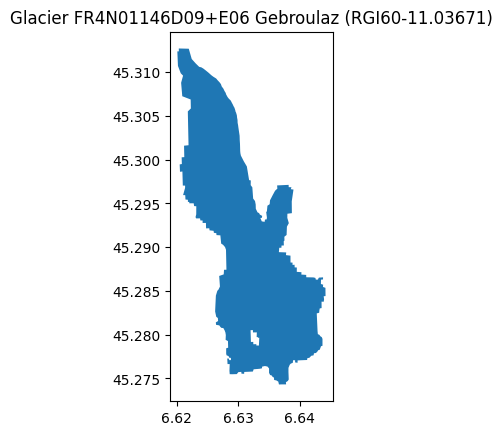

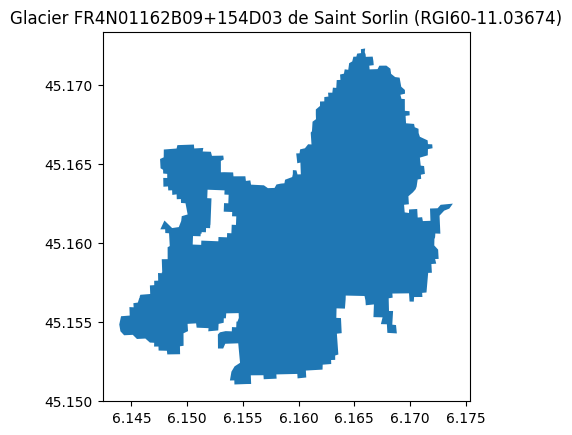

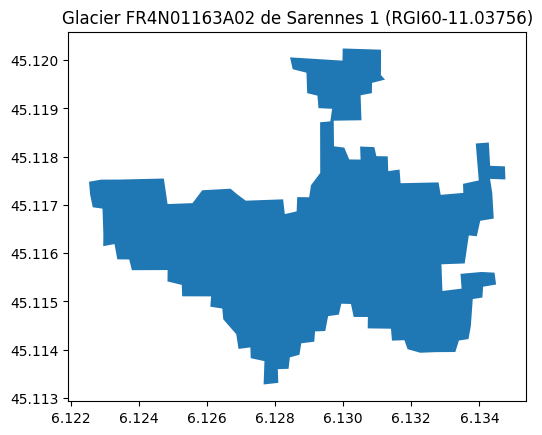

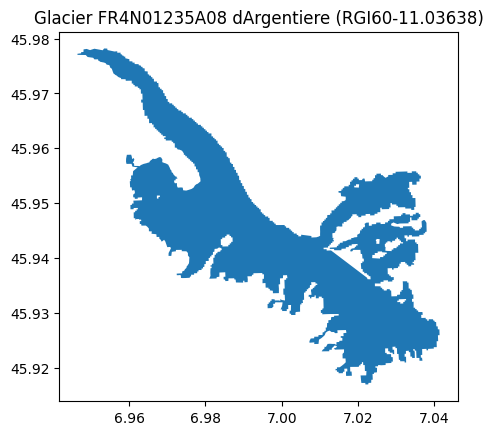

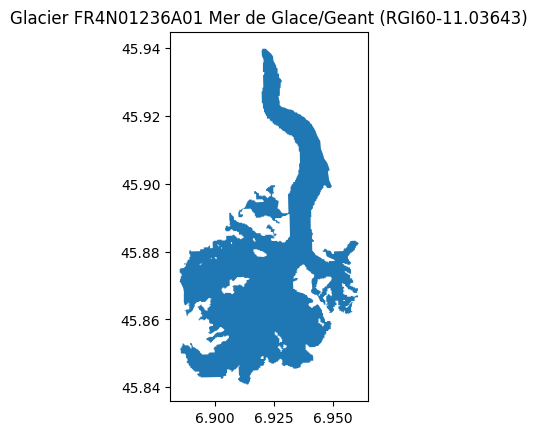

Found matches:
               RGIId                                 Name    Area
3428  RGI60-11.03429       FR4N01144B24 de l'Argentiere 1   0.157
3670  RGI60-11.03671           FR4N01146D09+E06 Gebroulaz   3.569
3754  RGI60-11.03755       FR4N01154E01 de l'Argentiere 2   0.128
3673  RGI60-11.03674  FR4N01162B09+154D03 de Saint Sorlin   2.741
3755  RGI60-11.03756           FR4N01163A02 de Sarennes 1   0.303
3756  RGI60-11.03757           FR4N01163A02 de Sarennes 2   0.012
3637  RGI60-11.03638             FR4N01235A08 dArgentiere  13.795
3642  RGI60-11.03643      FR4N01236A01 Mer de Glace/Geant  24.179


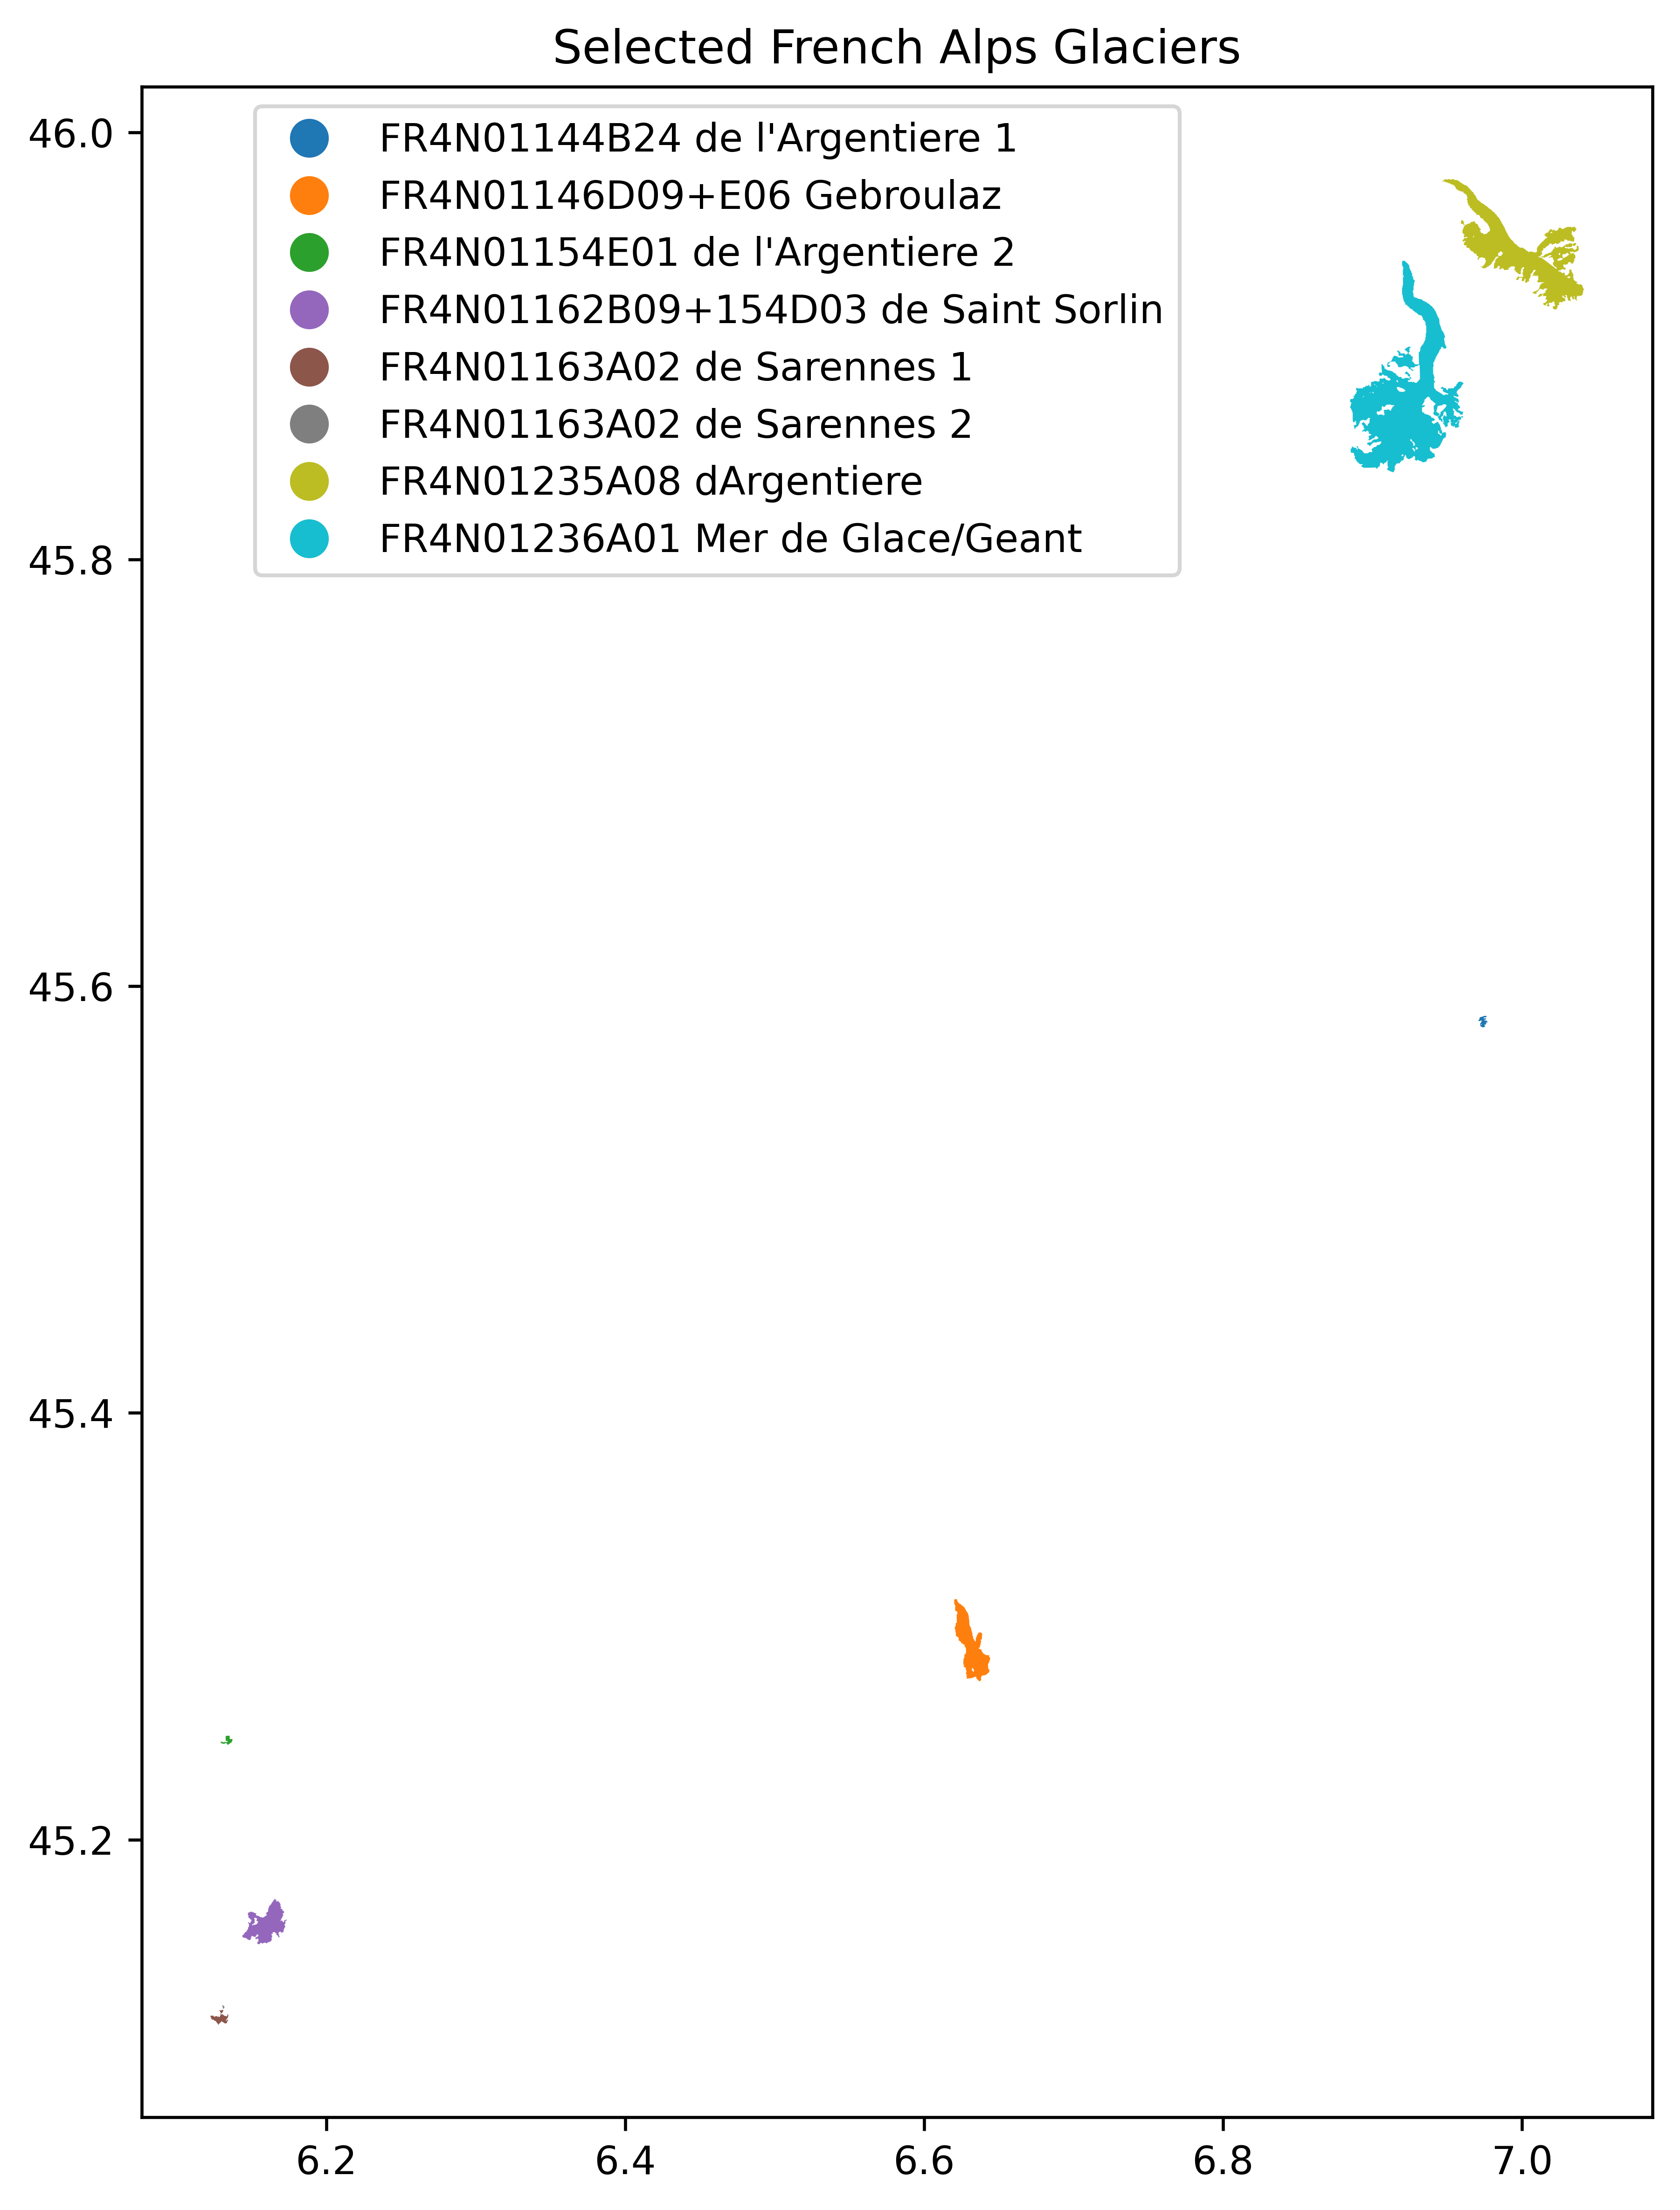

In [8]:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '/home/vmarijn/scratch/data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'
# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# List of RGI IDs and their names
glacier_ids = [
    'RGI60-11.03671',  # Gebroulaz CORRECT
    'RGI60-11.03674',  # Saint Sorlin CORRECT
    'RGI60-11.03756',  # Sarennes 1
    'RGI60-11.03638',  # Argentiere main CORRECT
    'RGI60-11.03643'   # Mer de Glace/Geant CORRECT
]

# Plot each glacier individually
for glacier_id in glacier_ids:
    glacier = glacier_outline[glacier_outline['RGIId'] == glacier_id]
    if not glacier.empty:
        glacier.plot()
        plt.title(f"Glacier {glacier.iloc[0]['Name']} ({glacier_id})")
        plt.show()
    else:
        print(f"Glacier with ID {glacier_id} not found")


# List of glaciers to search for
glacier_names = [
    "Argentiere",
    "Saint Sorlin",
    "Sarennes",
    "Mer de Glace",
    "Gebroulaz"
]

# Create an empty mask
mask = glacier_outline['Name'].str.lower().str.contains(glacier_names[0].lower(), na=False)

# Add other glacier names to the mask using OR operation
for name in glacier_names[1:]:
    mask = mask | glacier_outline['Name'].str.lower().str.contains(name.lower(), na=False)

# Get matching glaciers
matches = glacier_outline[mask]

# Display results
print("Found matches:")
print(matches[['RGIId', 'Name', 'Area']].sort_values('Name'))

# Plot the glaciers
if not matches.empty:
    fig, ax = plt.subplots(figsize=(12, 8), dpi=600)
    matches.plot(ax=ax, column='Name', legend=True, legend_kwds={'bbox_to_anchor': (0.7, 1)})
    plt.title("Selected French Alps Glaciers")
    plt.tight_layout()
    plt.show()
else:
    print("No matching glaciers found")

In [9]:
## visually confirmed the RG IDs of the glaciers and adding them manually.

stakes_csv_WGMS_RGIID = stakes_csv_WGMS.copy()

glacier_rgi_mapping = {
    'Argentiere': 'RGI60-11.03638', # Argentiere_main
    'stso': 'RGI60-11.03674',       # Saint Sorlin
    'sarennes': 'RGI60-11.03756',   # Using Sarennes 1, still have to check if it's correct
    'mdg': 'RGI60-11.03643',        # Mer de Glace/Geant
    'geb': 'RGI60-11.03671'         # Gebroulaz
}

# Loop through each glacier's dataframe and assign RGI IDs
for key, df in stakes_csv_WGMS_RGIID.items():
    glacier_name = df['GLACIER'].iloc[0]  # Get glacier name from first row
    if glacier_name in glacier_rgi_mapping:
        stakes_csv_WGMS_RGIID[key]['RGIId'] = glacier_rgi_mapping[glacier_name]
    else:
        print(f"Warning: No RGI ID mapping found for glacier: {glacier_name}")

# Verify the assignments
for key, df in stakes_csv_WGMS_RGIID.items():
    print(f"\nGlacier {key}:")
    print(f"Name: {df['GLACIER'].iloc[0]}")
    print(f"Assigned RGI ID: {df['RGIId'].iloc[0]}")


Glacier mdg_langue_winter_smb_abl_2001:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2005:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2016:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2014:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2002:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2022:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2018:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2015:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2006:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2019:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2017:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Glacier mdg_langue_winter_smb_abl_2013:
Name: mdg
Assigned RGI ID: RGI60-11.03643

Gla

##### 5. Combined the dictionary of dfs into 1 df

In [10]:
# Print every row
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Convert dictionary to single DataFrame
stakes_csv_WGMS_combined = pd.concat(stakes_csv_WGMS_RGIID.values(), ignore_index=True)

# Sort by date and glacier
stakes_csv_WGMS_combined = stakes_csv_WGMS_combined.sort_values(['GLACIER', 'GLACIER_ZONE', 'PERIOD', 'FROM_DATE'])

# Give the glaciers proper names
glacier_names = {
    'mdg': 'Mer_de_Glace',
    'stso': 'Saint-Sorlin',
    'geb': 'Gebroulaz',
    'sarennes': 'Sarennes'
}
stakes_csv_WGMS_combined['GLACIER'] = stakes_csv_WGMS_combined['GLACIER'].map(glacier_names).fillna(stakes_csv_WGMS_combined['GLACIER'])

print(f"Combined {len(stakes_csv_WGMS_combined)} measurements from {stakes_csv_WGMS_combined['GLACIER'].nunique()} glaciers")
print(stakes_csv_WGMS_combined)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

# Add YEAR column to df
stakes_csv_WGMS_combined['YEAR'] = stakes_csv_WGMS_combined['TO_DATE'].astype(str).str[:4].astype(int)

# Save the combined DataFrame to a CSV file
output_path = '/home/mburlet/DATA_MBM/GLACIOCLIM/WGMS_all/FR_wgms_dataset_all.csv'
stakes_csv_WGMS_combined.to_csv(output_path, index=False)

Combined 10913 measurements from 5 glaciers
                                                POINT_ID  POINT_LAT  \
7962          Argentiere_Tour_Noir_annual_smb_abl_2006_1  45.944607   
7963          Argentiere_Tour_Noir_annual_smb_abl_2006_2  45.943724   
7964          Argentiere_Tour_Noir_annual_smb_abl_2006_3  45.943192   
7965          Argentiere_Tour_Noir_annual_smb_abl_2006_4  45.942539   
7903          Argentiere_Tour_Noir_annual_smb_abl_2007_1  45.944594   
7904          Argentiere_Tour_Noir_annual_smb_abl_2007_2  45.943703   
7905          Argentiere_Tour_Noir_annual_smb_abl_2007_3  45.943188   
7906          Argentiere_Tour_Noir_annual_smb_abl_2007_4  45.942534   
7907         Argentiere_Tour_Noir_annual_smb_abl_2007_11  45.944312   
7908         Argentiere_Tour_Noir_annual_smb_abl_2007_12  45.943417   
7909         Argentiere_Tour_Noir_annual_smb_abl_2007_13  45.942868   
7910         Argentiere_Tour_Noir_annual_smb_abl_2007_14  45.942272   
7887          Argentiere_Tour_Noi

## Add RGIs Ids:

For each PMB measurement, we want to add the RGI ID (v6) of the shapefile it belongs to. 

In [ ]:
# take all winter and annual stakes (lots of snow probes)
df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1')

# Keep relevant WGMS columns:
df_pmb = df_all_raw[[
    'YEAR',
    'POINT_ID',
    'GLACIER',
    'FROM_DATE',
    'TO_DATE',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_BALANCE',
    'PERIOD',
]]

# Add RGIs:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '/home/vmarijn/scratch/data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'

# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# Add RGI IDs through intersection
df_pmb = mbm.data_processing.utils.get_rgi(data=df_pmb,
                                           glacier_outlines=glacier_outline)

# Handle unmatched points
no_match_df = df_pmb[df_pmb['RGIId'].isna()]
geometry = [
    Point(lon, lat)
    for lon, lat in zip(no_match_df["POINT_LON"], no_match_df["POINT_LAT"])
]
points_gdf = gpd.GeoDataFrame(no_match_df,
                              geometry=geometry,
                              crs=glacier_outline.crs)

for index in tqdm(no_match_df.index):
    point = points_gdf.loc[index]['geometry']
    polygon_index = glacier_outline.distance(point).sort_values().index[0]
    closest_rgi = glacier_outline.loc[polygon_index].RGIId
    df_pmb.at[index, 'RGIId'] = closest_rgi

In [ ]:
# Preprocess data
rgiids6 = df_pmb[['GLACIER', 'RGIId']].drop_duplicates()
print("RGIs before pre-processing:")
check_multiple_rgi_ids(rgiids6)

# Clean the data
df_pmb_clean = clean_rgi_ids(df_pmb.copy())
df_pmb_clean.reset_index(drop=True, inplace=True)

# Verify post-processing
rgiids6_clean = df_pmb_clean[['GLACIER', 'RGIId']].drop_duplicates()
print("RGIs after pre-processing:")
check_multiple_rgi_ids(rgiids6_clean)

## Cut from 1951:

In [ ]:
# Filter to start of MS data (1951) or ERA5-Land data (1950):
df_pmb_50s = df_pmb_clean[df_pmb_clean.YEAR > 1950].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])

# Change from mm w.e. to m w.e.
df_pmb_50s['POINT_BALANCE'] = df_pmb_50s['POINT_BALANCE'] / 1000

# merge ClaridenL and ClaridenU into one glacier:
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenU', 'GLACIER'] = 'clariden'
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenL', 'GLACIER'] = 'clariden'

print('Number of winter and annual samples:', len(df_pmb_50s))
print('Number of annual samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'winter']))

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s.groupby(['YEAR',
                    'PERIOD']).size().unstack().plot(kind='bar',
                                                     stacked=True,
                                                     color=[color_1, color_2],
                                                     ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

### Merge stakes that are close: 
Especially with winter probes, a lot of measurements were done at the same place in the raw data and this leads to noise. We merge the stakes that are very close and keep the mean of the measurement.


In [ ]:
# clean df_pmb_50s
# Group similar stakes:
df_pmb_50s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_50s.GLACIER.unique(), desc='glacier', position=0):
    print('----------------\n', gl, ':\n----------------')
    df_gl = df_pmb_50s[df_pmb_50s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_50s_clean = pd.concat([df_pmb_50s_clean, df_gl_cleaned])

# save to csv:
df_pmb_50s_clean.drop(['x', 'y'],
                      axis=1).to_csv(path_PMB_GLAMOS_csv + f'df_pmb_all.csv',
                                     index=False)

# save coordinates:
df_pmb_50s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
                  'PERIOD']].to_csv(path_PMB_GLAMOS_csv +
                                    f'coordinate_50s_clean_all.csv')

In [ ]:
# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s_clean.groupby(['YEAR', 'PERIOD'
                          ]).size().unstack().plot(kind='bar',
                                                   stacked=True,
                                                   color=[color_1, color_2],
                                                   ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s_clean.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

In [ ]:
glacier_list = list(df_pmb_50s_clean.GLACIER.unique())
print('Number of glaciers:', len(glacier_list))
glacier_list.sort()
glacier_list

In [ ]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_50s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

num_gl_annual = df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual'].groupby(
    ['GLACIER']).size().sort_values()

# Plot one glacier per column:
big_gl = num_gl_annual[num_gl_annual > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title

In [ ]:
print('Number of winter and annual samples:', len(df_pmb_50s_clean))
print('Number of annual samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'winter']))

## Add topographical information from OGGM:

In [ ]:
# Load the dataset
file_path = os.path.join(path_PMB_GLAMOS_csv, 'CH_wgms_dataset_all.csv')
df_pmb_topo = pd.read_csv(file_path)

# Remove 'pers' glacier
df_pmb_topo = df_pmb_topo.loc[df_pmb_topo.GLACIER != 'pers']

# Count and display the number of samples
print(f"Total number of winter and annual samples: {len(df_pmb_topo)}")

# Count occurrences of 'PERIOD' values
period_counts = df_pmb_topo['PERIOD'].value_counts()
print(f"Number of annual samples: {period_counts.get('annual', 0)}")
print(f"Number of winter samples: {period_counts.get('winter', 0)}")

# Unique years, sorted
unique_years = np.sort(df_pmb_topo.YEAR.unique())
print(f"Unique years: {unique_years}")

# Unique glaciers, sorted
glacier_list = sorted(df_pmb_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")

## Give new stake IDs:
Give new stake IDs with glacier name and then a number according to the elevation. This is because accross glaciers some stakes have the same ID which is not practical.

In [ ]:
for glacierName in tqdm(df_pmb_topo.GLACIER.unique(), desc='glaciers'):
    gl_data = df_pmb_topo[df_pmb_topo.GLACIER == glacierName]
    stakeIDS = gl_data.groupby('POINT_ID')[[
        'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION'
    ]].mean()
    stakeIDS.reset_index(inplace=True)
    # Change the ID according to elevation
    new_ids = stakeIDS[['POINT_ID',
                        'POINT_ELEVATION']].sort_values(by='POINT_ELEVATION')
    new_ids['POINT_ID_new'] = [
        f'{glacierName}_{i}' for i in range(len(new_ids))
    ]
    for i, row in new_ids.iterrows():
        df_pmb_topo.loc[(df_pmb_topo.GLACIER == glacierName) &
                        (df_pmb_topo.POINT_ID == row.POINT_ID),
                        'POINT_ID'] = row.POINT_ID_new

# Check the condition
check_point_ids_contain_glacier(df_pmb_topo)
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))

# Save to csv:
df_pmb_topo.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
                   index=False)

# Histogram of mass balance
df_pmb_topo['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')

# Glacier wide MB:

## Obs: no fixed dates, but using observed periods.

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'obs' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])

# Transform all files to csv
emptyfolder(path_SMB_GLAMOS_csv + 'obs/')
for file in glamosfiles_smb:
    fileName = re.split('.dat', file)[0]
    processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                        path_SMB_GLAMOS_csv + 'obs/')

# Example:
fileName = 'aletsch_obs.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'obs/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

## Fix: with fixed periods (hydrological year).

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'fix' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])
# Transform all files to csv
emptyfolder(path_SMB_GLAMOS_csv + 'fix/')
for file in glamosfiles_smb:
    fileName = re.split('.dat', file)[0]
    processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                        path_SMB_GLAMOS_csv + 'fix/')

# Example:
fileName = 'aletsch_fix.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

# Potential incoming clear sky solar radiation:

Pre-process glamos data of Potential incoming clear sky solar radiation (pcsr) used as a topographical variable. One per day grid per glacier for one year only, depends on the glacier.

In [ ]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

glDirect = np.sort(os.listdir(path_pcsr + 'raw/')) # Glaciers with data

print('Number of glacier with clear sky radiation data:', len(glDirect))
print('Glaciers with clear sky radiation data:', glDirect)

In [ ]:
empty = False
if empty:
    emptyfolder(path_pcsr_save)
else:
    glProcessed = [
        re.search(r"xr_direct_(.*)\.nc", f).group(1)
        for f in os.listdir(path_pcsr_save)
    ]
    glDirect = list(set(glDirect) - set(glProcessed))

for glacierName in tqdm(glDirect, desc='glaciers', position=0):
    print(glacierName)
    grid = os.listdir(path_pcsr + 'raw/' + glacierName)
    grid_year = int(re.findall(r'\d+', grid[0])[0])
    daily_grids = os.listdir(path_pcsr + 'raw/' + glacierName + '/' + grid[0])
    # Sort by day number from 001 to 365
    daily_grids.sort()
    grids = []
    for fileName in daily_grids:
        if 'grid' not in fileName:
            continue

        # Load daily grid file
        file_path = path_pcsr + 'raw/' + glacierName + '/' + grid[
            0] + '/' + fileName
        metadata, grid_data = load_grid_file(file_path)
        grids.append(grid_data)

    # Take monthly means:
    monthly_grids = []
    for i in range(12):
        num_days_month = monthrange(grid_year, i + 1)[1]
        monthly_grids.append(
            np.mean(np.stack(grids[i * num_days_month:(i + 1) *
                                   num_days_month],
                             axis=0),
                    axis=0))

    monthly_grids = np.array(monthly_grids)
    num_months = monthly_grids.shape[0]

    # Convert to xarray (CH coordinates)
    data_array = convert_to_xarray(monthly_grids, metadata, num_months)

    # Convert to WGS84 (lat/lon) coordinates
    data_array_transf = transform_xarray_coords_lv03_to_wgs84(data_array)

    # Save xarray
    if glacierName == 'findelen':
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_adler.nc')
    elif glacierName == 'stanna':
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_sanktanna.nc')
    else:
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')

In [ ]:
# Number of processed glaciers:
print('Number of processed glaciers:', len(os.listdir(path_pcsr_save)))

# read an plot one file
xr_file = xr.open_dataset(path_pcsr_save + 'xr_direct_clariden.nc')
xr_file['grid_data'].plot(x='x', y='y', col='time', col_wrap=3)